In [1]:
import deconV as dV
from base import NSM, MSEM
import plot as pl

import glob, tqdm, time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm

from scipy.optimize import curve_fit

Global seed set to 0


In [2]:
dV.params = {
    "jupyter": True,
    "tqdm": True,
    "cell_type_key": "cellType",
    "layer": "ncounts",
    "index_col": 0,
    "selected_ct": ["alpha", "delta", "gamma", "beta"],
    # "selected_ct": ["0", "1", "2"],
    "model_type": "prob",
    "ignore_others": True,
    "n_top_genes": -1,
    "plot_pseudo_bulk": False,
    "lr": 0.01,
    "epochs": 5000,
    "fig_fmt": "png",
    "indir": "../../data/xin/",
    # "indir": "../../data/GSE136148/",
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

In [3]:
sadata = dV.read_data(os.path.join(dV.params["indir"], "sc.tsv"))
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 1097, genes: 25453


In [4]:
print("Reading bulk data...")
badata = dV.read_data(os.path.join(dV.params["indir"], "bulk.tsv"), is_bulk=True)
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 18, genes: 39849


In [5]:
print("Reading pheno data...")
pheno_df = pd.read_csv(os.path.join(dV.params["indir"], "pdata.tsv"), sep="\t", index_col=dV.params["index_col"])
pheno_df.index.name = None

sadata.obs = pd.concat([sadata.obs, pheno_df], axis=1)
assert dV.params["cell_type_key"] in sadata.obs.columns, f"{dV.params['cell_type_key']} not in obs columns"
sadata.obs[dV.params["cell_type_key"]] = sadata.obs[dV.params["cell_type_key"]].astype(str)
sadata.obs

Reading pheno data...


,sampleID,SubjectName,cellTypeID,cellType
AZ_A10,1,Non T2D 1,5,delta
AZ_A11,1,Non T2D 1,2,alpha
AZ_A12,1,Non T2D 1,5,delta
AZ_A2,1,Non T2D 1,9,gamma
AZ_A5,1,Non T2D 1,6,ductal
...,...,...,...,...
HP1509101_P23,8,Non T2D 6,13,PSC
HP1509101_P4,8,Non T2D 6,2,alpha
HP1509101_P7,8,Non T2D 6,4,co-expression
HP1509101_P8,8,Non T2D 6,6,ductal


In [6]:
print("Preprocessing data...")
sadata, badata = dV.preprocess(sadata, badata)
print("After preprocessing:")
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

assert sadata.shape[1] == badata.shape[1], "scRNA-seq and bulk RNA-seq data have different number of genes"

Preprocessing data...
After preprocessing:
scRNA-seq data - cells: 748, genes: 17390
bulk RNA-seq data - samples: 18, genes: 17390


In [7]:
cell_types = list(sadata.obs[dV.params['cell_type_key']].unique())
cell_types

['delta', 'alpha', 'gamma', 'beta']

In [39]:
decon = dV.DeconV(sadata, badata, cell_types, dV.params, use_sub_types=False, use_gene_weights=True, gene_weights_method="max")

In [40]:
decon.sub_cluster(n_neighbors=15)

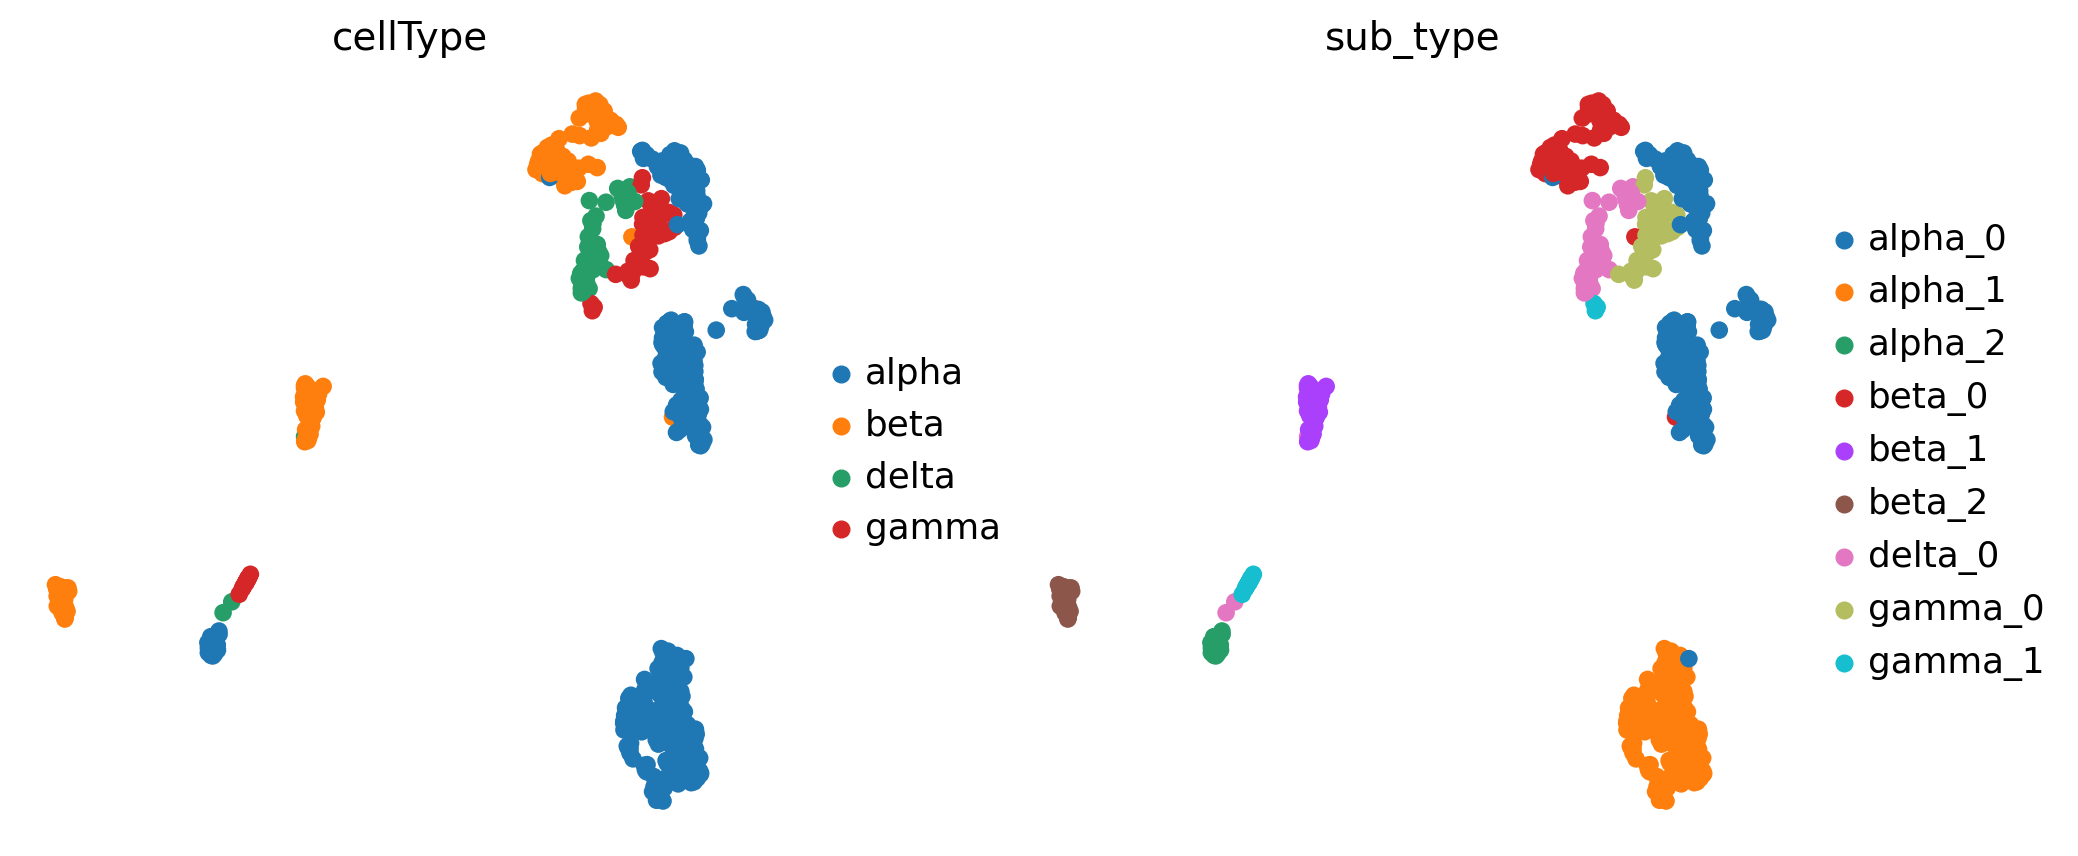

In [41]:
pl.umap_plot(decon, show=True, keys=[dV.params['cell_type_key'], "sub_type"], spread=1.0, min_dist=0.2)

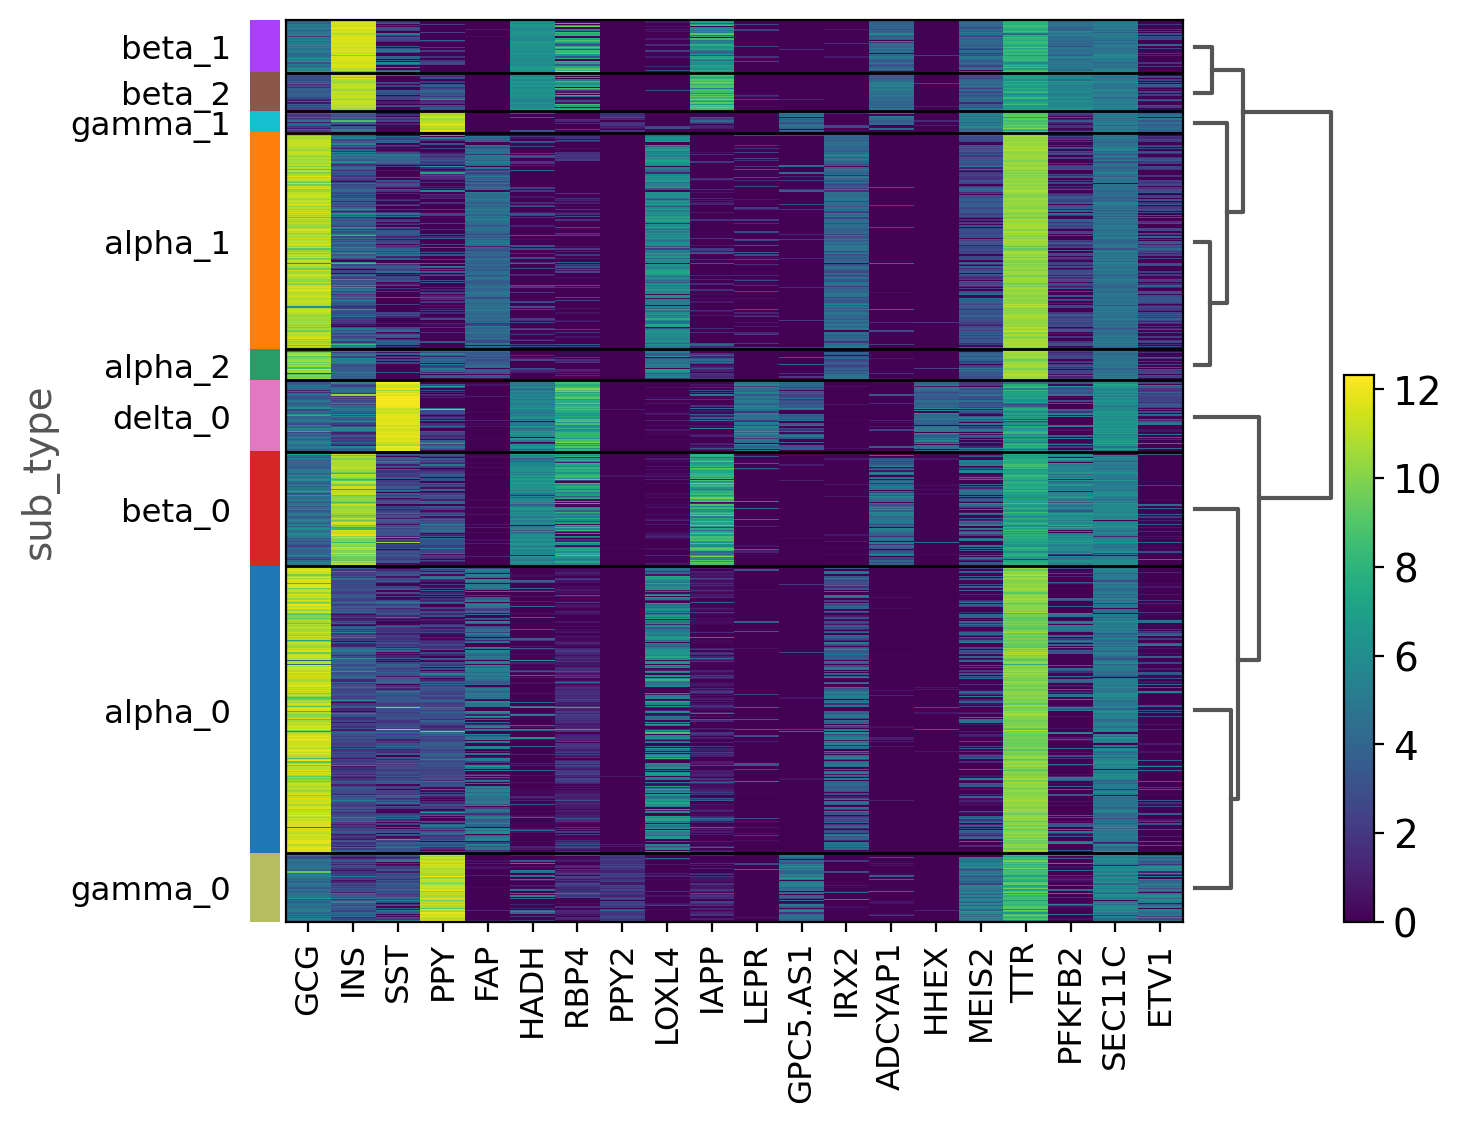

In [42]:
pl.marker_plot(decon, show=True)

In [43]:
decon.filter_outliers(dropout_mu_lim=2.5, dropout_lim=0.99, marker_zscore_lim=0.3, dispersion_lims=(-3, 1))

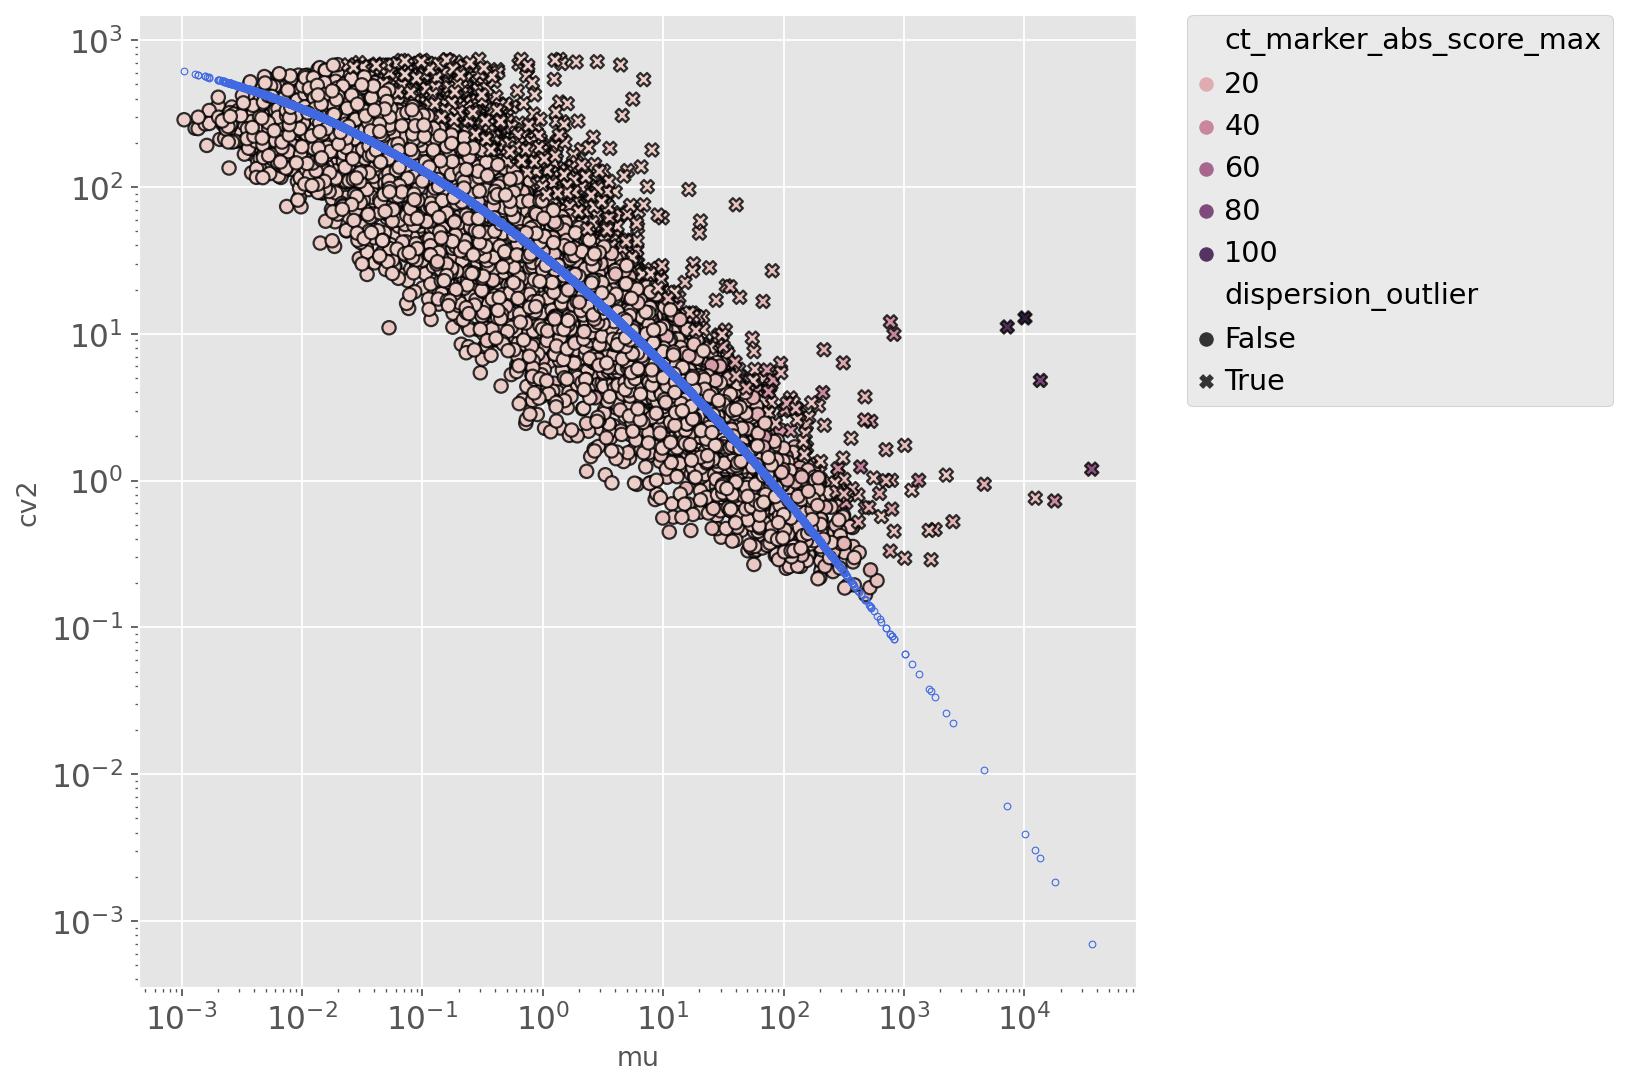

In [44]:
pl.dispersion_plot(decon, hue="ct_marker_abs_score_max", style="dispersion_outlier", figsize=(8,8), dpi=80, separate_ct=False)

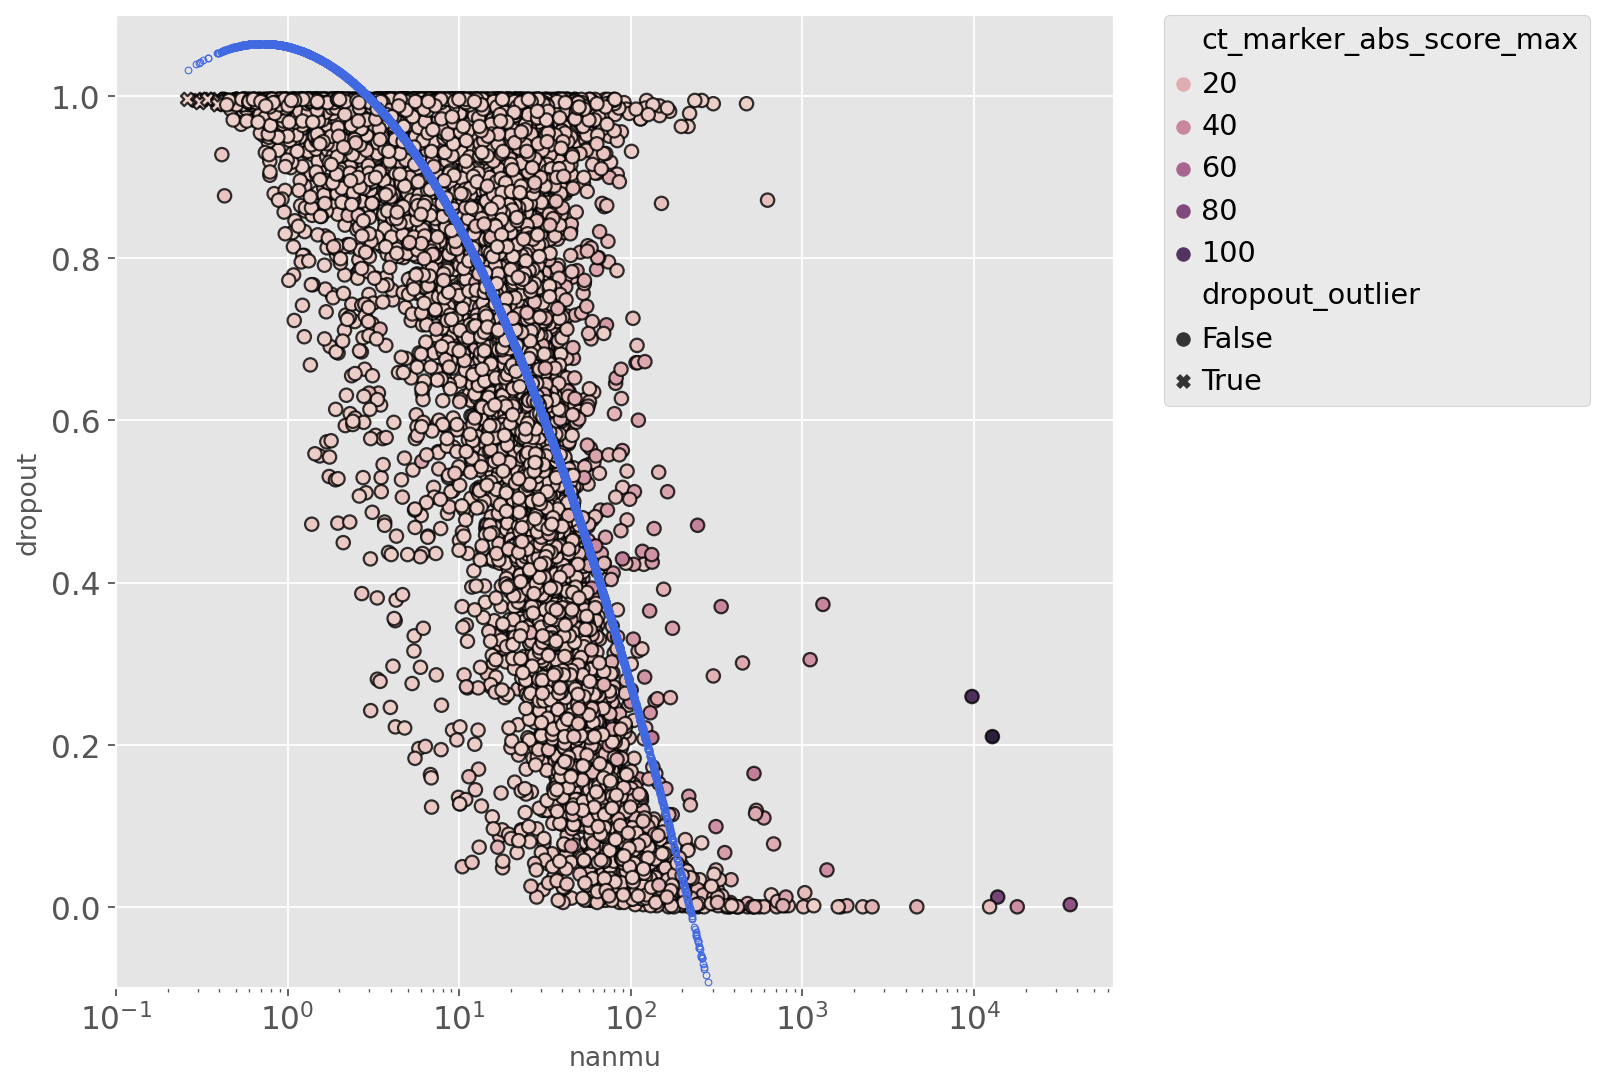

In [45]:
pl.dropout_plot(decon, hue="ct_marker_abs_score_max", style="dropout_outlier", xlim=(0.1, None), dpi=80, separate_ct=False)

In [46]:
# pl.dropout_plot(decon, hue="ct_marker_abs_score_max", style="dropout_outlier", separate_ct=True, xlim=(0.1, None), figsize=(6,6), dpi=80)

In [47]:
# pl.pseudo_bulk_plot(
#     decon, hue="ct_marker_abs_score_max", style="outlier", figsize=(6,6), dpi=80
# )

In [48]:
decon.init_dataset(use_outliers=False)
decon.init_signature()

Creating signature for cell types: ['delta_0', 'alpha_0', 'gamma_0', 'beta_0', 'beta_2', 'alpha_2', 'gamma_1', 'beta_1', 'alpha_1']...


/home/lutrarutra/Documents/dev/fimm/deconv/project/deconV.py:245: RuntimeWarning: divide by zero encountered in true_divide
  self.normalising_constant = 1.0 / torch.tensor(np.nanmean(np.nan_to_num(self.sadata.layers["counts"].sum(0) / self.badata.layers["counts"], posinf=np.nan), axis=1))


In [49]:
decon.cell_types

['delta', 'alpha', 'gamma', 'beta']

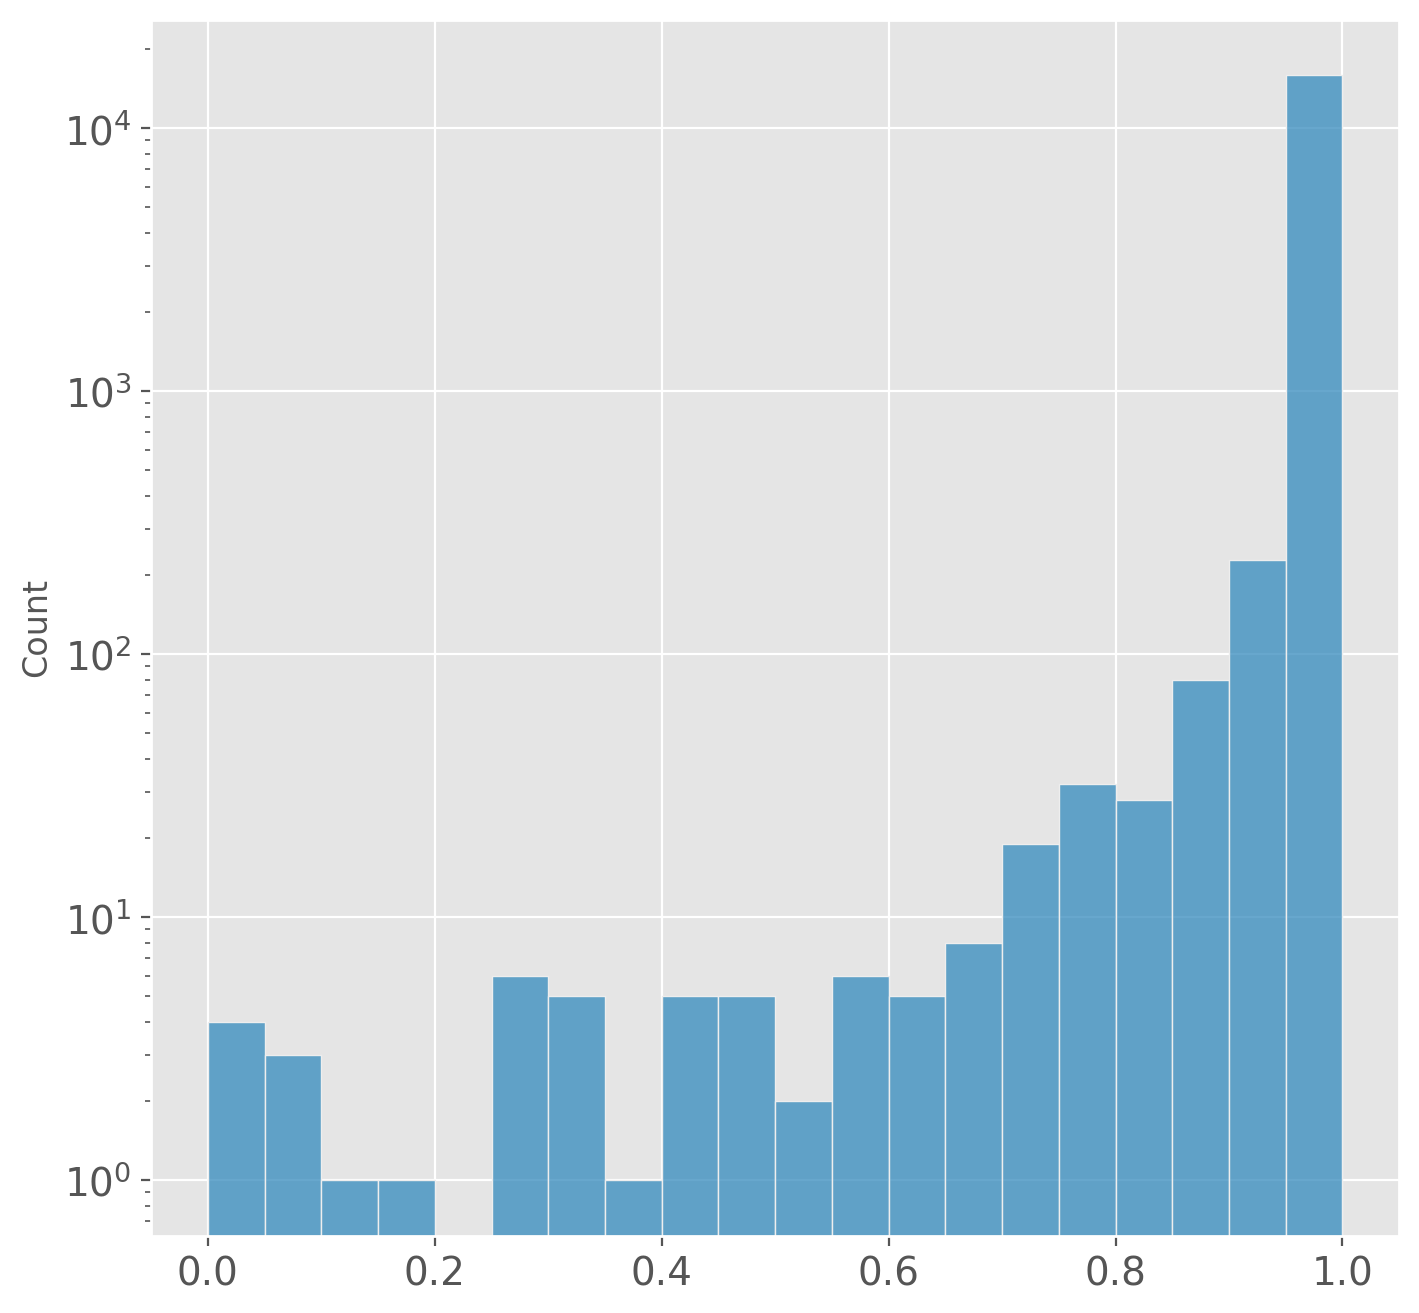

In [50]:
ax = sns.histplot(decon.gene_weights, bins=20, kde=False)
ax.set_yscale("log")

In [51]:
(decon.badata.layers["counts"] == 0).sum()

60783

Sample: 0/18


100%|██████████| 5000/5000 [00:04<00:00, 1185.00it/s, loss=17.7, props=0.01 0.04 0.07 0.27 0.13 0.01 0.01 0.01 0.44, lib_size=1505.0]


delta_0: 0.012 | alpha_0: 0.039 | gamma_0: 0.066 | beta_0: 0.273 | beta_2: 0.129 | alpha_2: 0.012 | gamma_1: 0.012 | beta_1: 0.012 | alpha_1: 0.445 | 
delta: 0.012 | alpha: 0.496 | gamma: 0.078 | beta: 0.414 | 
Sample: 1/18


100%|██████████| 5000/5000 [00:04<00:00, 1214.26it/s, loss=15.4, props=0.00 0.04 0.06 0.33 0.13 0.00 0.04 0.00 0.39, lib_size=1576.2]


delta_0: 0.001 | alpha_0: 0.045 | gamma_0: 0.059 | beta_0: 0.332 | beta_2: 0.134 | alpha_2: 0.001 | gamma_1: 0.043 | beta_1: 0.001 | alpha_1: 0.386 | 
delta: 0.001 | alpha: 0.432 | gamma: 0.102 | beta: 0.466 | 
Sample: 2/18


100%|██████████| 5000/5000 [00:04<00:00, 1175.99it/s, loss=20.5, props=0.01 0.07 0.09 0.25 0.38 0.01 0.01 0.01 0.17, lib_size=1247.7]


delta_0: 0.013 | alpha_0: 0.066 | gamma_0: 0.094 | beta_0: 0.248 | beta_2: 0.376 | alpha_2: 0.013 | gamma_1: 0.013 | beta_1: 0.013 | alpha_1: 0.166 | 
delta: 0.013 | alpha: 0.245 | gamma: 0.106 | beta: 0.637 | 
Sample: 3/18


100%|██████████| 5000/5000 [00:04<00:00, 1158.52it/s, loss=4.9, props=0.02 0.05 0.18 0.23 0.35 0.02 0.02 0.02 0.10, lib_size=1843.8]


delta_0: 0.024 | alpha_0: 0.048 | gamma_0: 0.177 | beta_0: 0.231 | beta_2: 0.350 | alpha_2: 0.024 | gamma_1: 0.024 | beta_1: 0.024 | alpha_1: 0.100 | 
delta: 0.024 | alpha: 0.171 | gamma: 0.200 | beta: 0.605 | 
Sample: 4/18


100%|██████████| 5000/5000 [00:04<00:00, 1195.79it/s, loss=5.8, props=0.01 0.12 0.10 0.28 0.17 0.01 0.01 0.01 0.27, lib_size=1045.4]


delta_0: 0.015 | alpha_0: 0.123 | gamma_0: 0.098 | beta_0: 0.284 | beta_2: 0.168 | alpha_2: 0.015 | gamma_1: 0.015 | beta_1: 0.015 | alpha_1: 0.269 | 
delta: 0.015 | alpha: 0.406 | gamma: 0.112 | beta: 0.467 | 
Sample: 5/18


100%|██████████| 5000/5000 [00:04<00:00, 1159.30it/s, loss=5.4, props=0.00 0.03 0.07 0.56 0.11 0.00 0.06 0.00 0.15, lib_size=1221.5]


delta_0: 0.003 | alpha_0: 0.033 | gamma_0: 0.074 | beta_0: 0.564 | beta_2: 0.108 | alpha_2: 0.003 | gamma_1: 0.064 | beta_1: 0.003 | alpha_1: 0.148 | 
delta: 0.003 | alpha: 0.184 | gamma: 0.138 | beta: 0.675 | 
Sample: 6/18


100%|██████████| 5000/5000 [00:04<00:00, 1201.95it/s, loss=14.5, props=0.00 0.06 0.07 0.41 0.22 0.00 0.03 0.00 0.21, lib_size=1604.2]


delta_0: 0.001 | alpha_0: 0.057 | gamma_0: 0.073 | beta_0: 0.409 | beta_2: 0.218 | alpha_2: 0.001 | gamma_1: 0.033 | beta_1: 0.001 | alpha_1: 0.208 | 
delta: 0.001 | alpha: 0.265 | gamma: 0.106 | beta: 0.628 | 
Sample: 7/18


100%|██████████| 5000/5000 [00:04<00:00, 1199.18it/s, loss=3.0, props=0.00 0.08 0.09 0.30 0.07 0.00 0.04 0.00 0.42, lib_size=1019.9]


delta_0: 0.003 | alpha_0: 0.084 | gamma_0: 0.087 | beta_0: 0.298 | beta_2: 0.069 | alpha_2: 0.003 | gamma_1: 0.035 | beta_1: 0.003 | alpha_1: 0.418 | 
delta: 0.003 | alpha: 0.505 | gamma: 0.123 | beta: 0.370 | 
Sample: 8/18


100%|██████████| 5000/5000 [00:04<00:00, 1211.59it/s, loss=1.3, props=0.01 0.05 0.10 0.43 0.25 0.01 0.01 0.01 0.11, lib_size=802.9]


delta_0: 0.014 | alpha_0: 0.055 | gamma_0: 0.097 | beta_0: 0.434 | beta_2: 0.247 | alpha_2: 0.014 | gamma_1: 0.014 | beta_1: 0.014 | alpha_1: 0.112 | 
delta: 0.014 | alpha: 0.181 | gamma: 0.111 | beta: 0.695 | 
Sample: 9/18


100%|██████████| 5000/5000 [00:04<00:00, 1175.30it/s, loss=1.8, props=0.05 0.09 0.10 0.28 0.38 0.00 0.05 0.00 0.04, lib_size=1102.7]


delta_0: 0.053 | alpha_0: 0.090 | gamma_0: 0.104 | beta_0: 0.282 | beta_2: 0.379 | alpha_2: 0.000 | gamma_1: 0.048 | beta_1: 0.000 | alpha_1: 0.043 | 
delta: 0.053 | alpha: 0.134 | gamma: 0.153 | beta: 0.661 | 
Sample: 10/18


100%|██████████| 5000/5000 [00:04<00:00, 1184.65it/s, loss=2.7, props=0.00 0.08 0.09 0.30 0.41 0.00 0.05 0.00 0.06, lib_size=1034.9]


delta_0: 0.003 | alpha_0: 0.085 | gamma_0: 0.091 | beta_0: 0.301 | beta_2: 0.406 | alpha_2: 0.003 | gamma_1: 0.048 | beta_1: 0.003 | alpha_1: 0.061 | 
delta: 0.003 | alpha: 0.149 | gamma: 0.138 | beta: 0.710 | 
Sample: 11/18


100%|██████████| 5000/5000 [00:04<00:00, 1202.44it/s, loss=2.0, props=0.00 0.10 0.06 0.22 0.00 0.00 0.00 0.00 0.59, lib_size=1023.1]


delta_0: 0.005 | alpha_0: 0.096 | gamma_0: 0.064 | beta_0: 0.225 | beta_2: 0.005 | alpha_2: 0.005 | gamma_1: 0.005 | beta_1: 0.005 | alpha_1: 0.592 | 
delta: 0.005 | alpha: 0.693 | gamma: 0.068 | beta: 0.234 | 
Sample: 12/18


100%|██████████| 5000/5000 [00:04<00:00, 1152.81it/s, loss=1.8, props=0.01 0.07 0.05 0.39 0.32 0.01 0.01 0.01 0.14, lib_size=654.6]


delta_0: 0.008 | alpha_0: 0.065 | gamma_0: 0.048 | beta_0: 0.391 | beta_2: 0.323 | alpha_2: 0.008 | gamma_1: 0.008 | beta_1: 0.008 | alpha_1: 0.140 | 
delta: 0.008 | alpha: 0.213 | gamma: 0.056 | beta: 0.722 | 
Sample: 13/18


100%|██████████| 5000/5000 [00:04<00:00, 1166.95it/s, loss=2.7, props=0.05 0.08 0.07 0.28 0.12 0.01 0.01 0.01 0.36, lib_size=660.1]


delta_0: 0.054 | alpha_0: 0.085 | gamma_0: 0.069 | beta_0: 0.275 | beta_2: 0.118 | alpha_2: 0.014 | gamma_1: 0.014 | beta_1: 0.014 | alpha_1: 0.356 | 
delta: 0.054 | alpha: 0.455 | gamma: 0.083 | beta: 0.408 | 
Sample: 14/18


100%|██████████| 5000/5000 [00:04<00:00, 1191.06it/s, loss=1.4, props=0.03 0.06 0.08 0.32 0.39 0.00 0.03 0.00 0.08, lib_size=873.4]


delta_0: 0.029 | alpha_0: 0.064 | gamma_0: 0.077 | beta_0: 0.317 | beta_2: 0.394 | alpha_2: 0.002 | gamma_1: 0.032 | beta_1: 0.002 | alpha_1: 0.083 | 
delta: 0.029 | alpha: 0.148 | gamma: 0.109 | beta: 0.713 | 
Sample: 15/18


100%|██████████| 5000/5000 [00:04<00:00, 1192.39it/s, loss=2.0, props=0.08 0.06 0.06 0.30 0.14 0.00 0.04 0.00 0.32, lib_size=1071.5]


delta_0: 0.082 | alpha_0: 0.057 | gamma_0: 0.059 | beta_0: 0.300 | beta_2: 0.135 | alpha_2: 0.003 | gamma_1: 0.040 | beta_1: 0.003 | alpha_1: 0.320 | 
delta: 0.082 | alpha: 0.380 | gamma: 0.099 | beta: 0.439 | 
Sample: 16/18


100%|██████████| 5000/5000 [00:04<00:00, 1186.31it/s, loss=2.3, props=0.10 0.15 0.08 0.22 0.26 0.01 0.01 0.01 0.15, lib_size=1650.9]


delta_0: 0.102 | alpha_0: 0.151 | gamma_0: 0.082 | beta_0: 0.222 | beta_2: 0.265 | alpha_2: 0.010 | gamma_1: 0.010 | beta_1: 0.010 | alpha_1: 0.148 | 
delta: 0.102 | alpha: 0.310 | gamma: 0.092 | beta: 0.496 | 
Sample: 17/18


100%|██████████| 5000/5000 [00:04<00:00, 1181.93it/s, loss=7.7, props=0.01 0.04 0.04 0.44 0.21 0.01 0.01 0.01 0.23, lib_size=1758.5]


delta_0: 0.011 | alpha_0: 0.037 | gamma_0: 0.043 | beta_0: 0.441 | beta_2: 0.206 | alpha_2: 0.011 | gamma_1: 0.011 | beta_1: 0.011 | alpha_1: 0.229 | 
delta: 0.011 | alpha: 0.277 | gamma: 0.054 | beta: 0.658 | 
Plotting results...


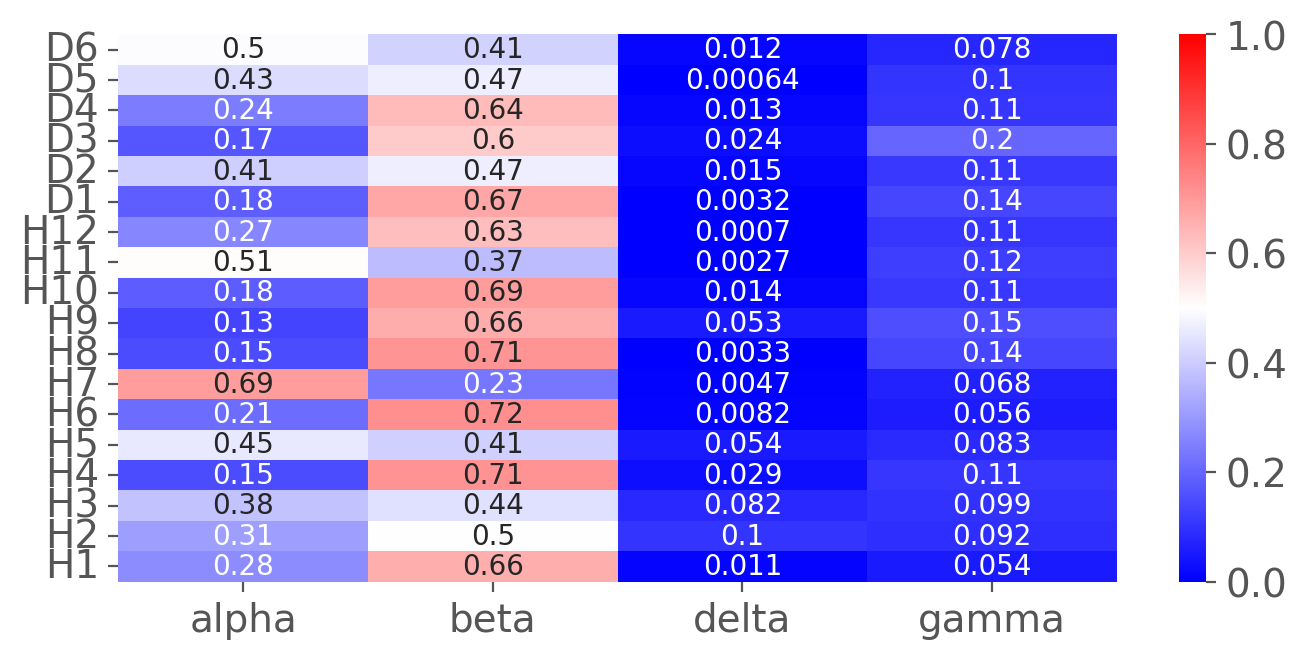

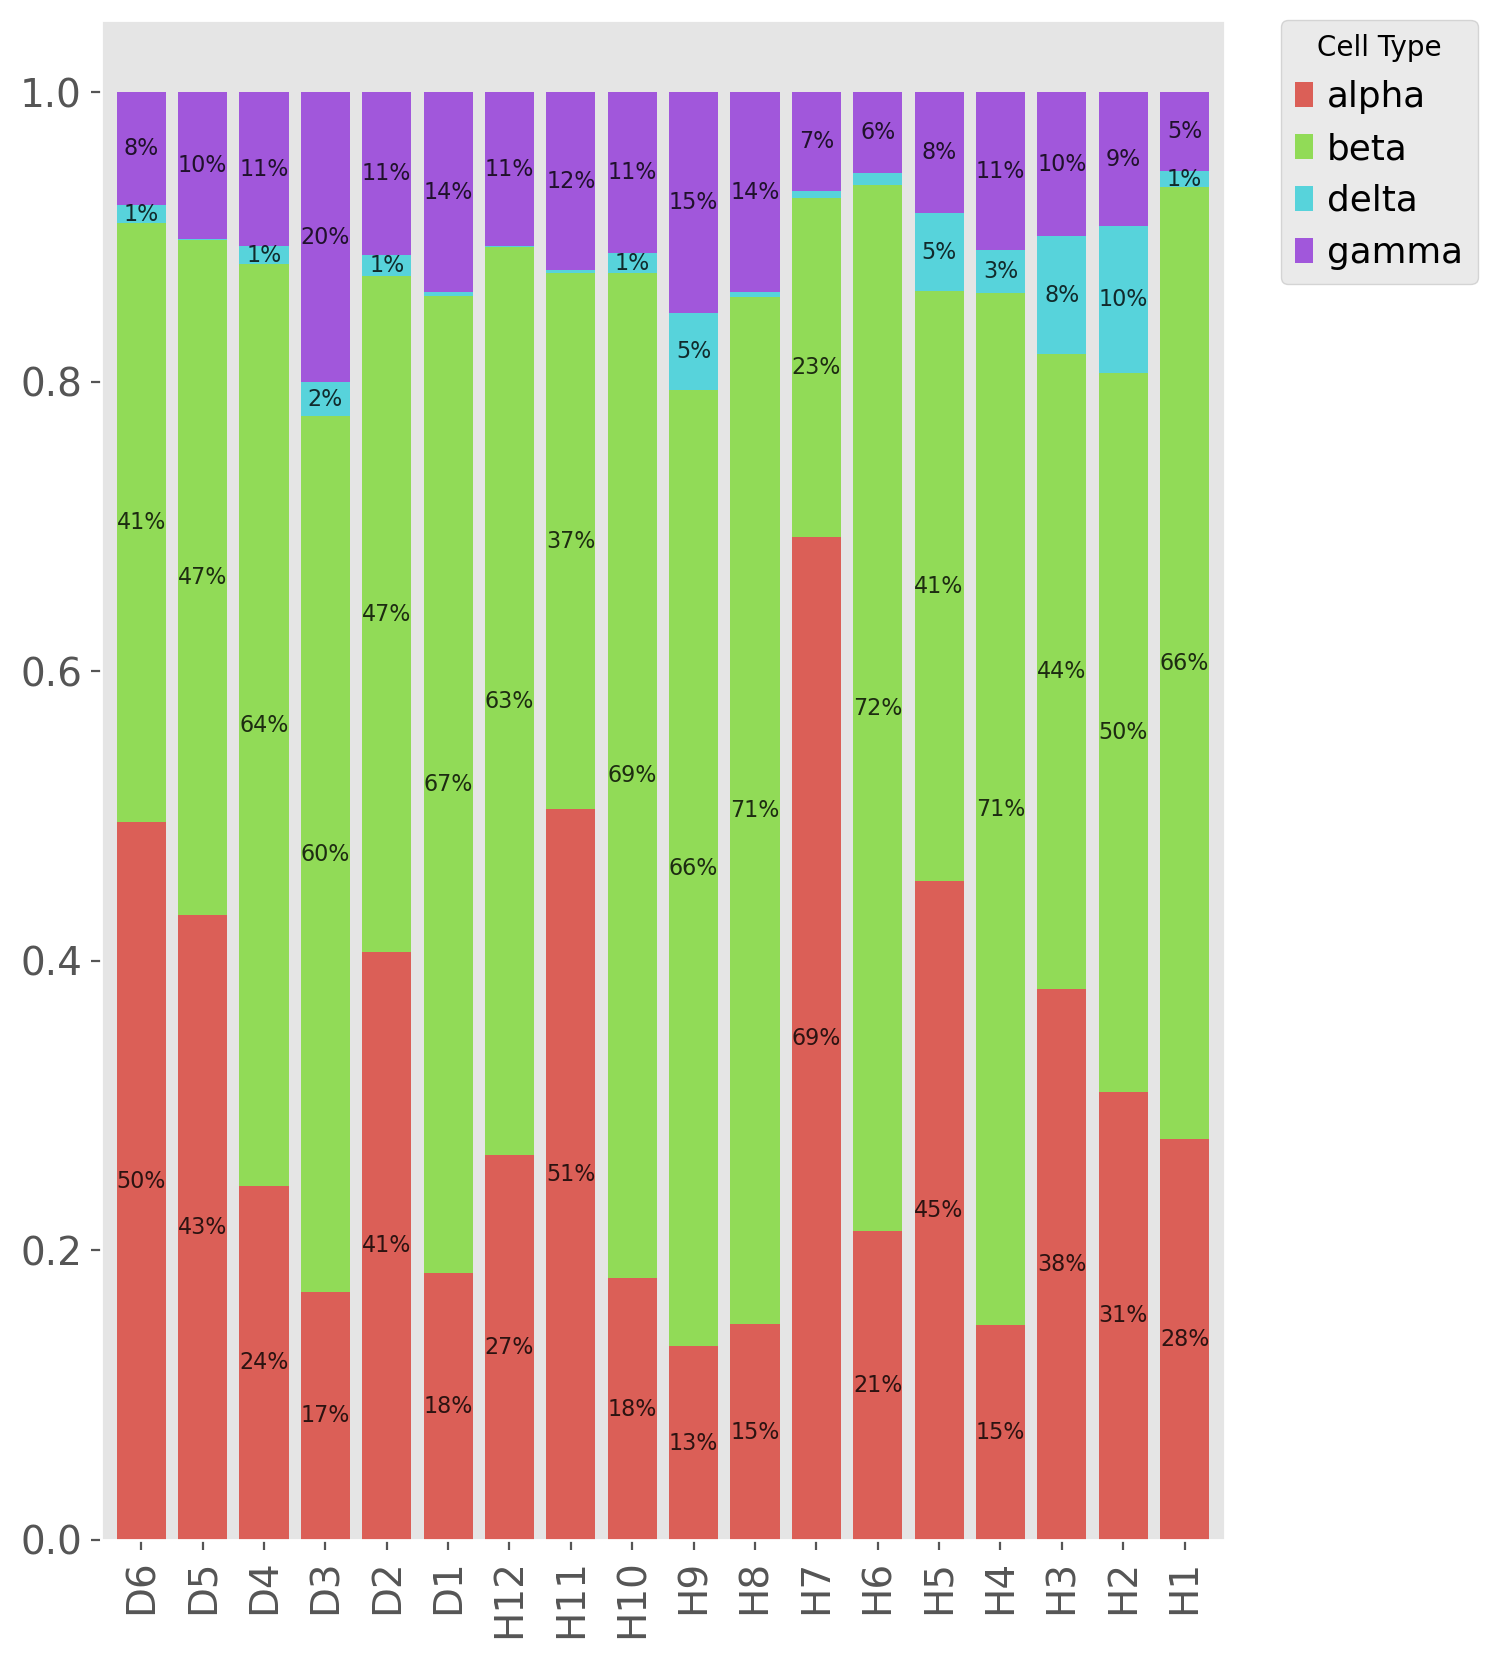

In [52]:
est_df = decon.deconvolute()

In [53]:
true_df = pd.read_csv("../../data/xin/true.tsv", "\t", index_col=0)

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


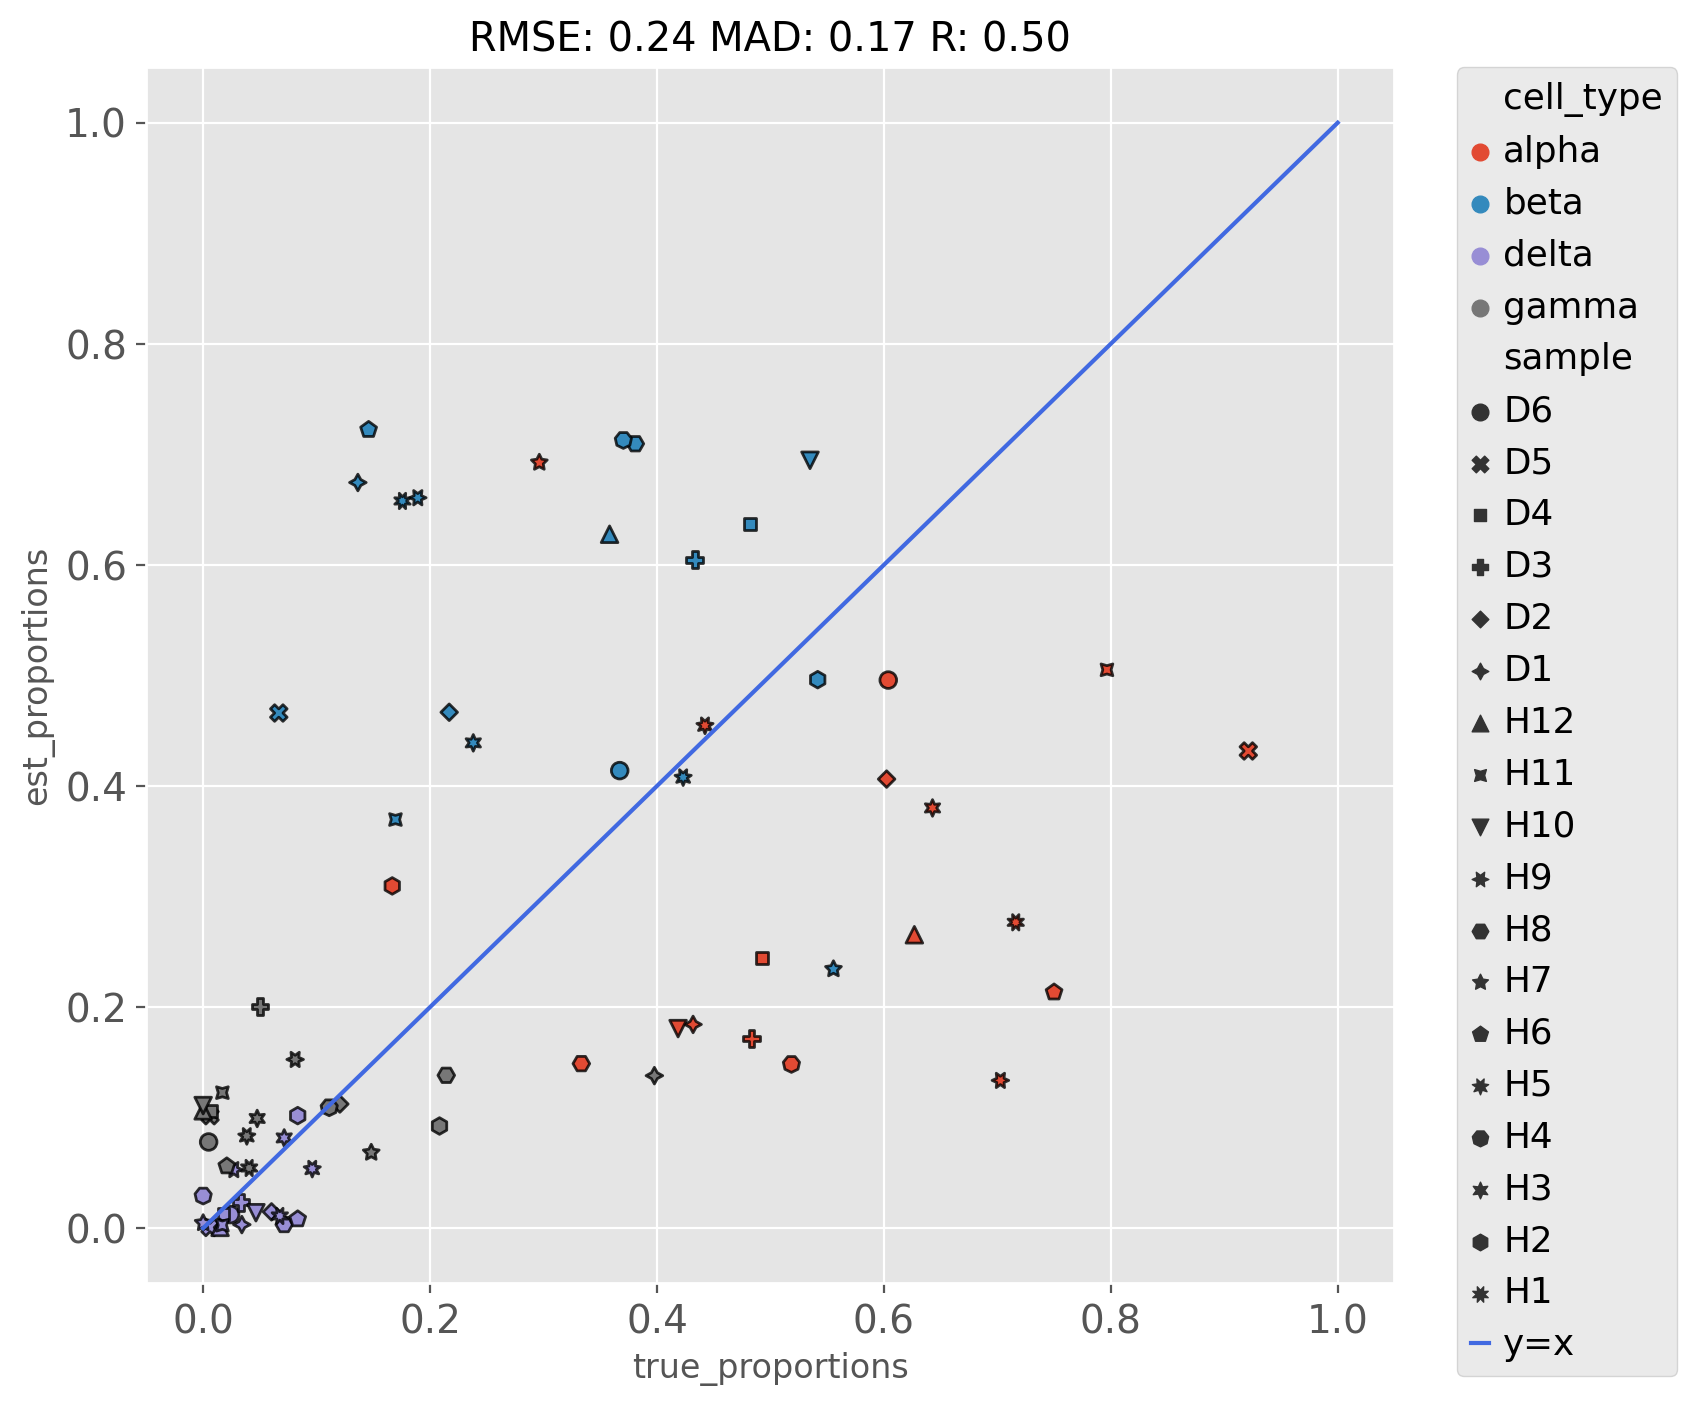

In [54]:
pl.scatter_check(true_df, est_df, style="sample")